# College Data Analysis with Python


In this question, you will use the dataset made available to the public by:

S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

The data is related to a direct marketing campaign conducted by a Portuguese financial institution. The raw dataset has been modified for the purpose of this assignment. The attached “Bank_partB.csv” file contains the following columns:

- Age : a continuous variable (respondent’s age)
- Job : type of job ("admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed","retired","technician","services")
- Marital status : single, married, divorced
- Education : unknown, primary, secondary, tertiary
- Balance : average yearly balance (in Euro) in the respondent’s bank account (negative amount means bank overdraft)
- Housing : whether the respondent has a housing loan (No vs Yes)
- Loan : whether the respondent has a personal loan (No vs Yes)

Hint: You need to transform categorial data into numerical data. For example, re-express “Education” as 0 (unknown), 1 (primary), 2 (secondary) and 3 (tertiary). Also, the data does not have any missing entries; hence, you don’t have to ‘clean’ the data.

Required: The classification goal is to evaluate the accuracy of the (chosen) model in predicting if a respondent will subscribe to the term deposit (No vs Yes) offered by the bank.

Use all the knowledge that you have gained in class on KNN-classification to address this problem. You are free to choose (i) which independent variable(s) to use, (ii) whether you want to estimate the classification model using the entire sample observations, or splitting the full sample into training and testing sets, and (iii) the optimal k-neighbor value. But you must be prepared to justify your decision. For example, if you choose the optimal k-neighbor value = 3, then discuss the rationale behind it.

### Data Collection

The data has been provided in the `bank_partB.csv` file and the column details are as discussed above in the question.

In [362]:
# Imports
# Base
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

# Metrics and hypertuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay


# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [363]:
# Create a dataframe of the data
df = pd.read_csv('./bank_partB.csv')
df.head()

,age,job,marital,education,balance,housing,loan,deposit
0,30,unemployed,married,primary,1787,no,no,no
1,33,services,married,secondary,4789,yes,yes,no
2,35,management,single,tertiary,1350,yes,no,no
3,30,management,married,tertiary,1476,yes,yes,no
4,59,blue-collar,married,secondary,0,yes,no,no


### Exploratory Data Analysis (EDA)

In [364]:
df.describe()

,age,balance
count,4521.000000,4521.000000
mean,41.170095,1422.657819
std,10.576211,3009.638142
min,19.000000,-3313.000000
25%,33.000000,69.000000
50%,39.000000,444.000000
75%,49.000000,1480.000000
max,87.000000,71188.000000


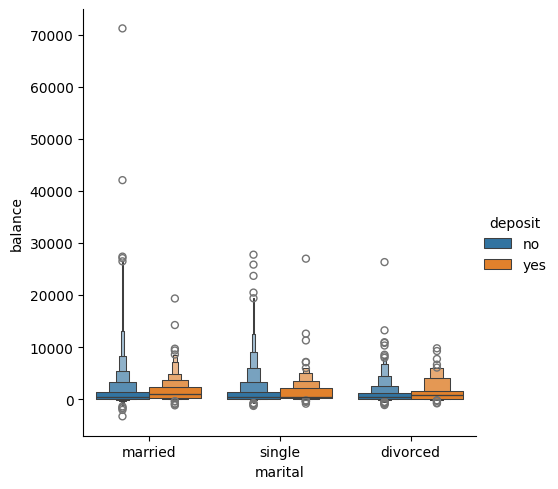

In [365]:
fig = sns.catplot(df, x='marital', y='balance', hue='deposit', kind='boxen')
plt.show()

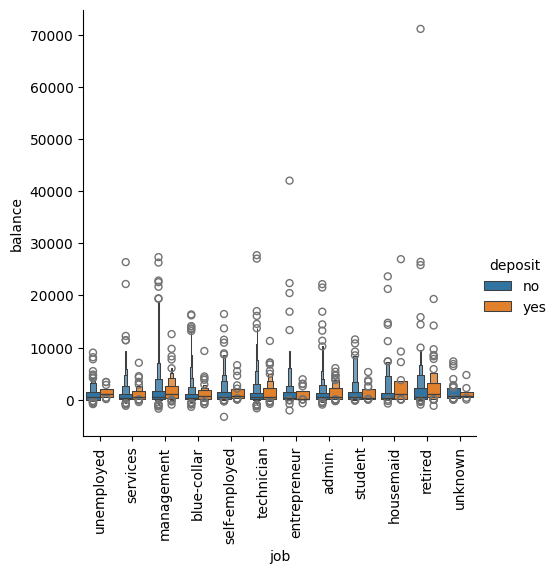

In [366]:
fig = sns.catplot(df, x='job', y='balance', hue='deposit', kind='boxen')
fig.set_xticklabels(rotation=90)

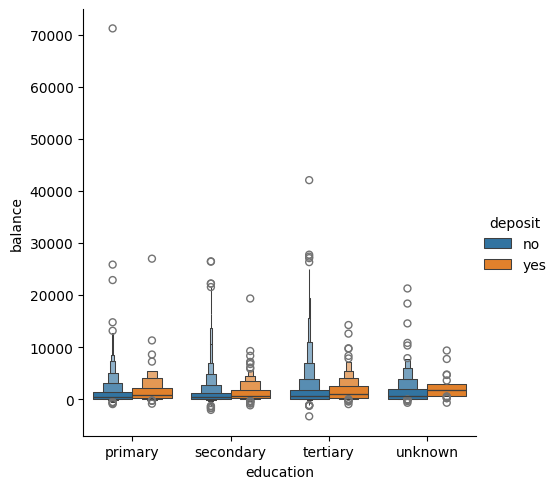

In [367]:
fig = sns.catplot(df, x='education', y='balance', hue='deposit', kind='boxen')
plt.show()

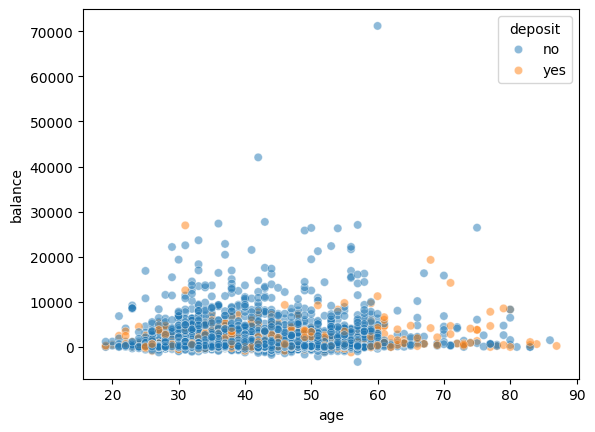

In [368]:
fig = sns.scatterplot(df, x='age', y='balance', hue='deposit', alpha=0.5)
plt.show()

### Cleaning Data

The dataset appears to be generally complete and there are no non-null values.

In [369]:
# Check for null values
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
loan         0
deposit      0
dtype: int64

### Transform Data

The categorical variables are also transformed into numeric values so that they can be handled by the model.


In [370]:
# Change the categorical variables into binary variables
# Transform job
def transform_job(x):
    if x == 'unemployed':
        return 0
    elif x == 'services':
        return 1
    elif x == 'management':
        return 2
    elif x == 'blue-collar':
        return 3
    elif x == 'self-employed':
        return 4
    elif x == 'technician':
        return 5
    elif x == 'entrepreneur':
        return 6
    elif x == 'admin':
        return 7
    elif x == 'student':
        return 8
    elif x == 'housemaid':
        return 9
    elif x == 'retired':
        return 10
    else:
        return 11 
# Transform marital
def transform_marital(x):
    if x == 'married':
        return 0
    elif x == 'single':
        return 1
    else:
        return 2 
# transform education
def transform_education(x):
    if x == 'primary':
        return 0
    elif x == 'secondary':
        return 1
    elif x == 'tertiary':
        return 2
    else:
        return 3 
# Transform yes/no
def transform_yes_no(x):
    if x == 'yes':
        return 1
    else:
        return 0
    
df['deposit'] = df['deposit'].apply(transform_yes_no)
df['housing'] = df['housing'].apply(transform_yes_no)
df['loan'] = df['loan'].apply(transform_yes_no)
df['marital'] = df['marital'].apply(transform_marital)
df['job'] = df['job'].apply(transform_job)
df['education'] = df['education'].apply(transform_education)

<Axes: >

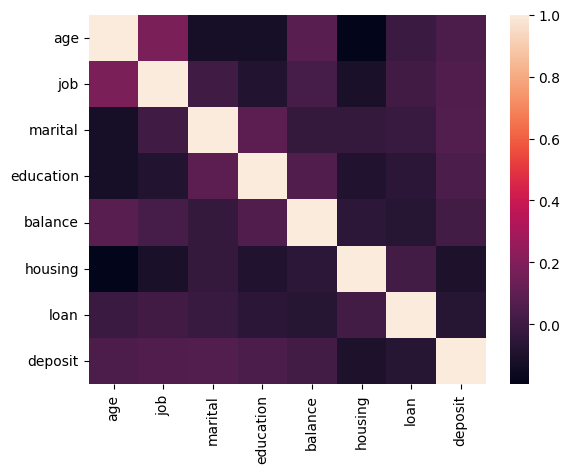

In [371]:
corr = df.corr()
sns.heatmap(corr)

In [372]:
X = df.drop('deposit', axis=1)
y = df['deposit']

The data still has 7 features. To explore reducing the number od features/dimensions further, I will use a filter method, K-best.

Using Scikit Learn's SelectKBest to choose the the k best features to use.

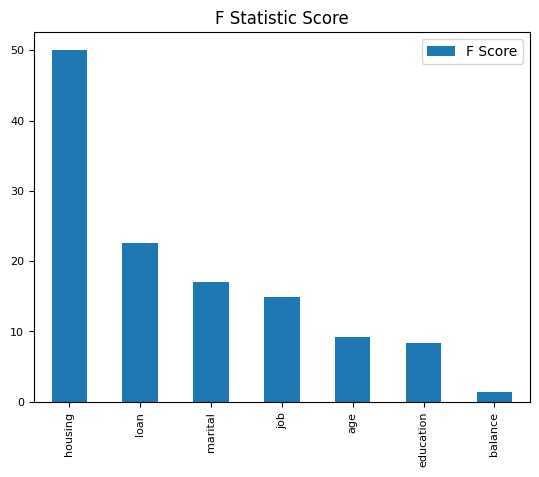

In [373]:
kbest = SelectKBest(k='all')
kbest.fit(X, y)
# Print the scores in descending order
scores_df = pd.DataFrame(kbest.scores_, index=X.columns, columns=['F Score']).sort_values('F Score',ascending=False)
fig = scores_df.plot(kind='bar', fontsize=8, title='F Statistic Score')
plt.show()

The balance feature has a very small f-score, which indicates that it contributes little to the model. Therefore, this feature will be dropped in the model.

In [374]:
# Drop the balance score
X = X.drop('balance', axis=1)

### Model

The model stipulated in the question is the K Nearest Neighbours.

Hyperparameter tuning will be accomplished using Grid Search with cross validation. This method will find the optimal k-neighbour value in a systematic way.

The data should also be scaled to ensure that the points of the hypercube are of similar values. This will mean that no feature will distort the model due to differences in the magnitude of the numbers involved.

Firstly, we will make a prediction on "out of the box" settings to see what we are dealing with. 

In [375]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [376]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [377]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [378]:
out_of_box = classification_report(y_test, clf.predict(X_test))
print(out_of_box)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1300
           1       0.25      0.04      0.07       192

    accuracy                           0.86      1492
   macro avg       0.56      0.51      0.50      1492
weighted avg       0.79      0.86      0.81      1492



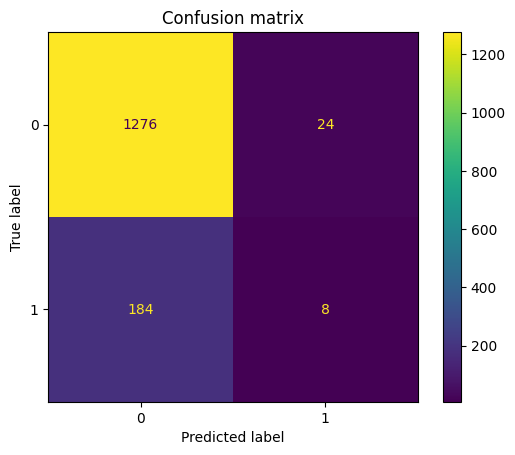

In [379]:
confusion = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title('Confusion matrix')
plt.show()

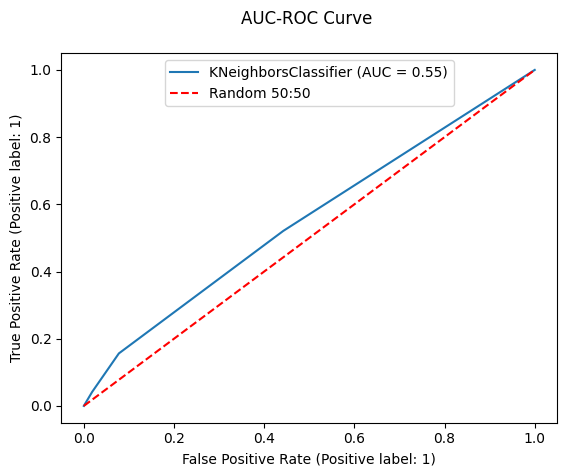

In [380]:
roc = RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("AUC-ROC Curve \n")
plt.plot([0, 1], [0, 1], linestyle="--", label='Random 50:50', color='red')
plt.legend(loc='upper center')
plt.show()

It is clear that with the initial parameters set, our model predicts barely better than random, although the AUC-ROC curve does indicate that there is some predictive power. Now we will move onto hyperparameter tuning and cross validation to attempt to increase the predictive power of the model.

Cross validation is where the training data is split into small sets and part of the data is held out for validation. Classical cross validation assumes data samples are independent and identically distributed. This isn't necessarily the case but using this feature will reduce over fitting.

For parameters, I will focus on the k-neighbors parameter and test this systematically to find the best value for the model.

In [392]:
param_grid = {
    'n_neighbors': np.arange(2, 51, 1),
    'weights': ['uniform', 'distance']
}
gs = GridSearchCV(clf, param_grid, verbose=1, scoring='balanced_accuracy')
gs.fit(X_train, y_train)

Fitting 5 folds for each of 98 candidates, totalling 490 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy', verbose=1)

In [393]:
gs.best_params_

{'n_neighbors': 3, 'weights': 'uniform'}

### Validation

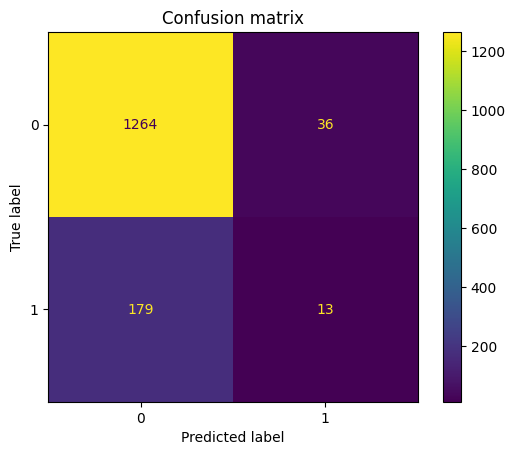

In [394]:
confusion = ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test)
plt.title('Confusion matrix')
plt.show()

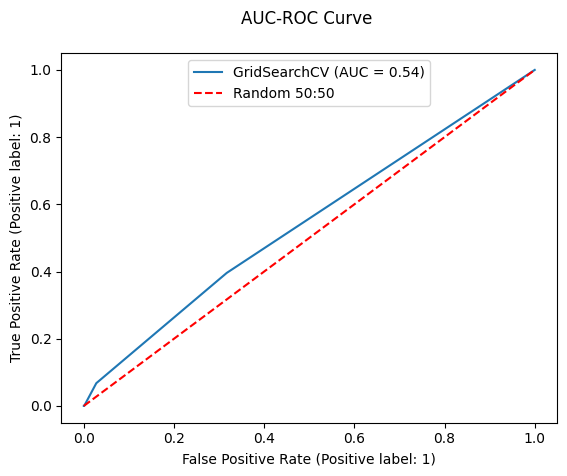

In [395]:
roc = RocCurveDisplay.from_estimator(gs, X_test, y_test)
plt.title("AUC-ROC Curve \n")
plt.plot([0, 1], [0, 1], linestyle="--", label='Random 50:50', color='red')
plt.legend(loc='upper center')
plt.show()

In [396]:
print('Tuned model')
print(classification_report(y_test, gs.predict(X_test)))
print('Original model')
print(out_of_box)

Tuned model
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1300
           1       0.27      0.07      0.11       192

    accuracy                           0.86      1492
   macro avg       0.57      0.52      0.51      1492
weighted avg       0.80      0.86      0.82      1492

Original model
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1300
           1       0.25      0.04      0.07       192

    accuracy                           0.86      1492
   macro avg       0.56      0.51      0.50      1492
weighted avg       0.79      0.86      0.81      1492



Although the overall accuracy fo the model accuracy has improved by 0.04 and has correctly classified 56% of days, the models predictive power is only slightly better than random. This is further demonstrated by the confusion matrix and ROC curve.

However, the precision of "1" (i.e. predicting an upward trend) is no better than a coin flip with only 17% of positive cases being caught. All in all, I wouldn't use my own money to test this strategy....